In [ ]:
# !pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modeling import FoldSet, GridSearch_ML, MLTest
from RNN_modeling import Make_DataSet
from correlation import Correlation
from visualization import Result_pred, Plot_Result

# Load data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Jjdata.csv')
print(df.shape)
df

(8474, 14)


,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2018-08-01,경남 진주시,6,0.019,24.0,22.7,0.0,0.0,88.0,1004.2,0.01,3.0,1962.0,8
1,2018-08-01,경남 진주시,7,0.086,31.0,26.2,0.2,0.0,77.0,1004.1,0.38,0.0,1976.0,8
2,2018-08-01,경남 진주시,8,0.160,17.0,27.5,1.0,290.0,68.0,1004.0,1.03,0.0,2000.0,8
3,2018-08-01,경남 진주시,9,0.191,18.0,29.9,2.1,20.0,56.0,1004.0,1.78,2.0,2000.0,8
4,2018-08-01,경남 진주시,10,0.212,23.0,32.2,1.5,50.0,46.0,1003.8,2.41,1.0,2000.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8469,2020-09-16,경남 진주시,17,18.000,33.0,22.8,0.8,140.0,86.0,1009.0,0.53,10.0,1988.0,9
8470,2020-09-16,경남 진주시,18,2.000,36.0,22.7,1.0,110.0,89.0,1008.4,0.25,5.0,1738.0,9
8471,2020-09-17,경남 진주시,7,9.000,31.0,21.0,0.5,340.0,97.0,1011.3,0.01,10.0,631.0,9
8472,2020-09-17,경남 진주시,8,13.000,29.0,20.8,0.5,20.0,96.0,1011.6,0.06,10.0,916.0,9


In [ ]:
df['Area'].unique()

array(['경남 진주시'], dtype=object)

# Create Deviation Variable

In [ ]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time']]
cols

['Photovoltaics',
 'PM10',
 'Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Solar radiation',
 'Cloudy',
 'Visibility']

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev = True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)



In [ ]:
train_Jj = pd.concat([x_train, y_train], axis=1)
train_Jj

,dev_PM10,dev_Temperature,dev_Wind velocity,dev_Wind direction,dev_Humidity,dev_Sea-level pressure,dev_Solar radiation,dev_Cloudy,dev_Visibility,dev_Photovoltaics
0,-3.448276,-0.329310,-0.458621,-46.896552,-1.844828,-3.489655,0.008103,-2.224138,759.293103,-7.643224
1,3.150000,2.071667,-0.360000,-50.500000,-9.533333,-3.978333,0.208000,-5.216667,688.966667,-23.473683
2,-10.983871,1.866129,0.138710,149.838710,-12.419355,-4.270968,0.433871,-5.629032,518.903226,-45.389903
3,-10.451613,2.966129,0.825806,-150.161290,-18.677419,-4.241935,0.659355,-3.822581,436.274194,-61.853258
4,-6.295082,4.018033,0.114754,-136.229508,-23.065574,-4.516393,0.833934,-5.163934,401.721311,-68.236836
...,...,...,...,...,...,...,...,...,...,...
5830,-27.355932,-6.123729,1.298305,157.457627,-21.406780,7.359322,0.542203,-3.694915,357.050847,145.521051
5831,-24.733333,-5.963333,1.023333,161.833333,-18.483333,7.558333,0.584500,-4.383333,319.833333,100.017733
5832,-22.483871,-6.404839,1.745161,128.548387,-13.500000,7.187097,0.515806,-4.370968,277.209677,41.688290
5833,-22.262295,-6.036066,0.727869,184.098361,-17.803279,7.375410,0.416066,-4.491803,264.295082,8.251836


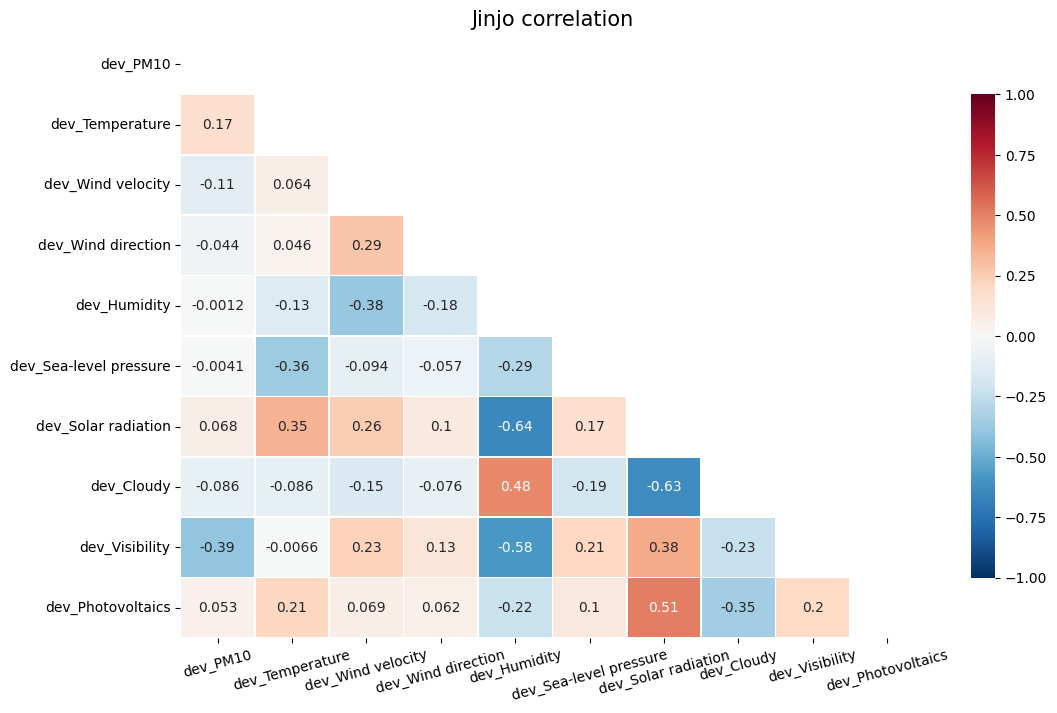

In [ ]:
c = Correlation(train_Jj, train_Jj.columns, 'Jinjo')

# Fine-tuning the model

In [ ]:
params = {}

In [ ]:
# params = GridSearch_ML(df, cols, params, dev=True)
# params = GridSearch_ML(df, cols, params)

In [ ]:
params['dev_MLP'] = {'activation': 'identity', 'hidden_layer_sizes': (300,), 'learning_rate': 'constant', 'max_iter': 2000, 'solver': 'adam'}
params['dev_LGBM'] = {'boosting': 'dart', 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'mse', 'num_leaves': 31, 'objective': 'regression'}
params['ori_MLP'] = {'activation': 'identity', 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'adam'}
params['ori_LGBM'] = {'boosting': 'dart', 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'mse', 'num_leaves': 31, 'objective': 'regression'}

In [ ]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'identity', 'hidden_layer_sizes': (300,), 'learning_rate': 'constant', 'max_iter': 2000, 'solver': 'adam'}
dev_LGBM {'boosting': 'dart', 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'mse', 'num_leaves': 31, 'objective': 'regression'}
ori_MLP {'activation': 'identity', 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'adam'}
ori_LGBM {'boosting': 'dart', 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'mse', 'num_leaves': 31, 'objective': 'regression'}


# Model Learning

## LR 
(LinearRegression)

In [ ]:
# score점수 저장
score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

In [ ]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)

train: (975, 9), (975, 1) valid: (972, 9), (972, 1)

train: (1947, 9), (1947, 1) valid: (972, 9), (972, 1)

train: (2919, 9), (2919, 1) valid: (972, 9), (972, 1)

train: (3891, 9), (3891, 1) valid: (972, 9), (972, 1)

train: (4863, 9), (4863, 1) valid: (972, 9), (972, 1)

LinearRegression()


In [ ]:
ignore = MLTest(df, 'LR', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)

train: (975, 9), (975, 1) valid: (972, 9), (972, 1)

train: (1947, 9), (1947, 1) valid: (972, 9), (972, 1)

train: (2919, 9), (2919, 1) valid: (972, 9), (972, 1)

train: (3891, 9), (3891, 1) valid: (972, 9), (972, 1)

train: (4863, 9), (4863, 1) valid: (972, 9), (972, 1)

LinearRegression()


## MLP 
(MLPRegressor)

In [ ]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)

train: (975, 9), (975, 1) valid: (972, 9), (972, 1)

train: (1947, 9), (1947, 1) valid: (972, 9), (972, 1)

train: (2919, 9), (2919, 1) valid: (972, 9), (972, 1)

train: (3891, 9), (3891, 1) valid: (972, 9), (972, 1)

train: (4863, 9), (4863, 1) valid: (972, 9), (972, 1)

MLPRegressor(activation='identity', hidden_layer_sizes=(300,), max_iter=2000)


In [ ]:
ignore = MLTest(df, 'MLP', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)

train: (975, 9), (975, 1) valid: (972, 9), (972, 1)

train: (1947, 9), (1947, 1) valid: (972, 9), (972, 1)

train: (2919, 9), (2919, 1) valid: (972, 9), (972, 1)

train: (3891, 9), (3891, 1) valid: (972, 9), (972, 1)

train: (4863, 9), (4863, 1) valid: (972, 9), (972, 1)

MLPRegressor(activation='identity', hidden_layer_sizes=(200,),
             learning_rate='adaptive', max_iter=2000)


## LGBM
 (LGBMRegressor)

In [ ]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)

train: (975, 9), (975, 1) valid: (972, 9), (972, 1)

train: (1947, 9), (1947, 1) valid: (972, 9), (972, 1)

train: (2919, 9), (2919, 1) valid: (972, 9), (972, 1)

train: (3891, 9), (3891, 1) valid: (972, 9), (972, 1)

train: (4863, 9), (4863, 1) valid: (972, 9), (972, 1)



In [ ]:
ignore = MLTest(df, 'LGBM', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (5835, 9), (5835, 1) test: (2639, 9), (2639, 1)

train: (975, 9), (975, 1) valid: (972, 9), (972, 1)

train: (1947, 9), (1947, 1) valid: (972, 9), (972, 1)

train: (2919, 9), (2919, 1) valid: (972, 9), (972, 1)

train: (3891, 9), (3891, 1) valid: (972, 9), (972, 1)

train: (4863, 9), (4863, 1) valid: (972, 9), (972, 1)



# Score

In [ ]:
score

{'R2_dev_LR': 0.6508730775606208,
 'RMSE_dev_LR': 45.057804724400235,
 'R2_LR': 0.5911969223386102,
 'RMSE_LR': 48.75682722196085,
 'R2_dev_MLP': 0.648030245969748,
 'RMSE_dev_MLP': 45.240878623779864,
 'R2_MLP': 0.6044299446523065,
 'RMSE_MLP': 47.96120240451001,
 'R2_dev_LGBM': 0.5480519823404755,
 'RMSE_dev_LGBM': 51.265193547363005,
 'R2_LGBM': 0.027123349104391403,
 'RMSE_LGBM': 75.2154829928048}

In [ ]:
with open('/content/gdrive/MyDrive/SolarPower/Jinjo_score.txt','w',encoding='UTF-8') as f:
  for key, values in score.items():
    f.write(f'{key}:{values}\n')

# Shap plot

In [ ]:
# 모델 학습 후 shap 생성 함수
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False)
  plt.title(f"{model_name} Shap barplot", fontsize=15, pad=10)
  plt.show()
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.title(f"{model_name} Shap plot", fontsize=15, pad=10)
  plt.show()

Exact explainer: 5836it [00:58, 84.27it/s]                           


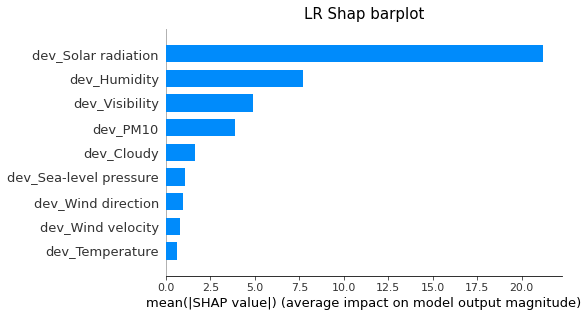

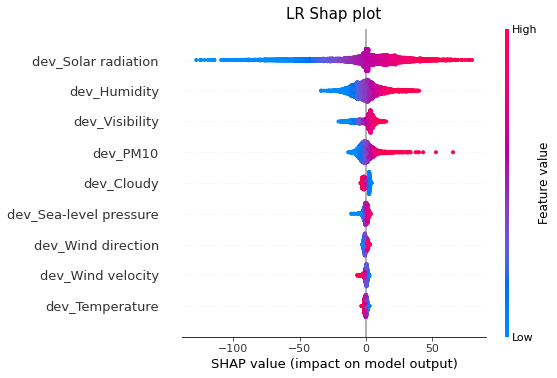

In [ ]:
ShapPlot(**Shap_dic['dev_LR'])

Exact explainer: 5836it [05:32, 16.98it/s]                          


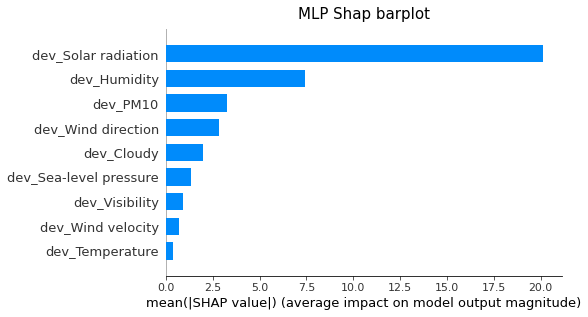

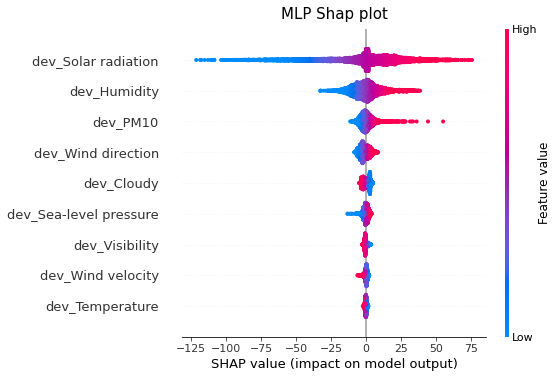

In [ ]:
ShapPlot(**Shap_dic['dev_MLP'])

Exact explainer: 5836it [12:29,  7.68it/s]


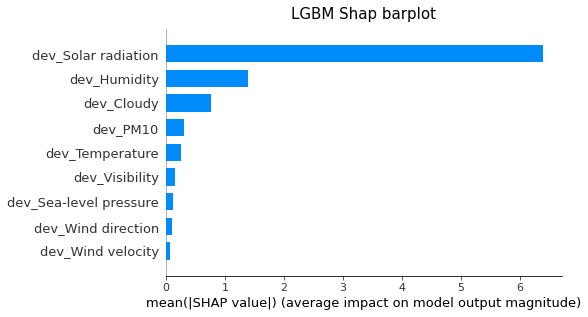

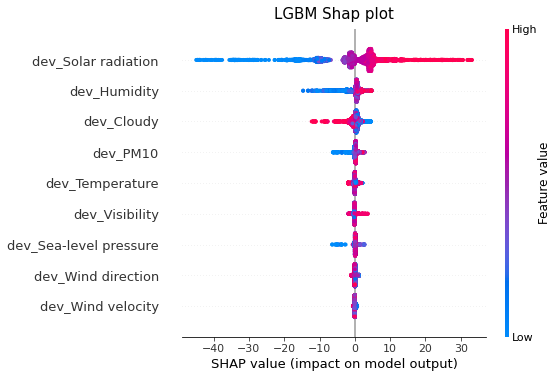

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

# Result

In [ ]:
testmn

,mean_Photovoltaics
0,23.258065
1,55.645161
2,104.290323
3,149.451613
4,191.966667
...,...
2634,8.345754
2635,1.902360
2636,15.402491
2637,31.716368


In [ ]:
data = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)

In [ ]:
data

,Area,Date,Month,Time,Photovoltaics,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,경남 진주시,2020-01-01,1,8,23.0,20.150052,20.246334,24.513892,23.258065
1,경남 진주시,2020-01-01,1,9,64.0,59.308167,61.347353,58.740266,55.645161
2,경남 진주시,2020-01-01,1,10,122.0,111.539066,112.889491,107.372294,104.290323
3,경남 진주시,2020-01-01,1,11,169.0,161.614952,161.240261,152.533584,149.451613
4,경남 진주시,2020-01-01,1,12,215.0,215.550956,215.198911,197.768238,191.966667
...,...,...,...,...,...,...,...,...,...
2634,경남 진주시,2020-09-16,9,17,18.0,13.109074,13.139894,6.847879,8.345754
2635,경남 진주시,2020-09-16,9,18,2.0,11.110275,11.807242,1.705280,1.902360
2636,경남 진주시,2020-09-17,9,7,9.0,8.646045,4.106587,13.110108,15.402491
2637,경남 진주시,2020-09-17,9,8,13.0,13.222346,14.552821,27.249986,31.716368


In [ ]:
data.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)

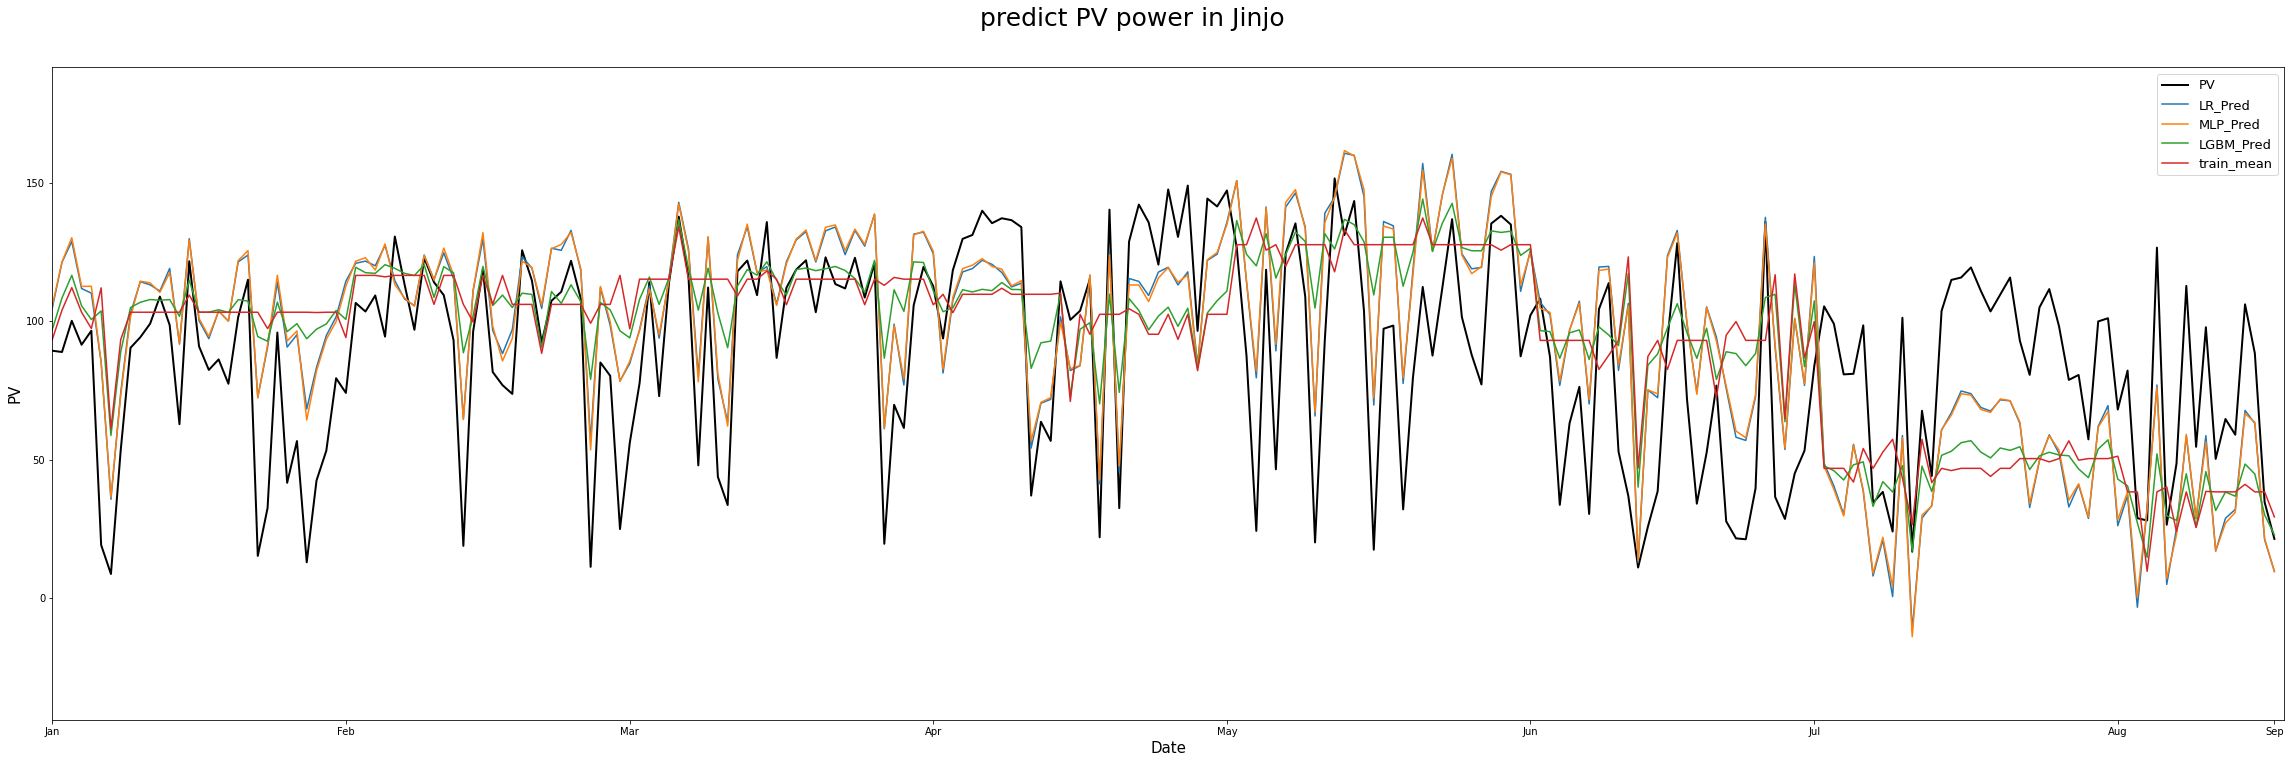

In [ ]:
Plot_Result(data, 'Jinjo')